In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import display, Markdown
from tqdm import tqdm
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
#Loading data
train_data = torchvision.datasets.MNIST(root='./data',train=True,download = True, transform = transforms.ToTensor())
test_data = torchvision.datasets.MNIST(root='./data',train=False,download = True, transform = transforms.ToTensor())

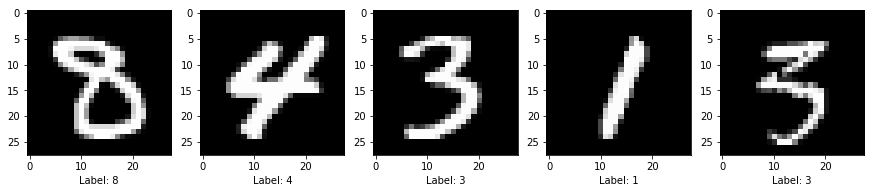

In [4]:
#Display 5 random training examples with labels
ind = random.sample(range(0,len(train_data)),5)
fig = plt.figure(figsize=(15,10))
for i,index in enumerate(ind):
    num = train_data[index][0].view(28,28)
    label = train_data[index][1]
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xlabel('Label: {}'.format(label))
    plt.imshow(num,cmap='gray')

In [5]:
#Split into train and val sets (75%,25% split)
x_train, x_val = torch.utils.data.random_split(train_data,[int(0.75*len(train_data)),int(0.25*len(train_data))])

In [6]:
#Splitting into batches
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=x_train,batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=x_val,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size)

In [7]:
#Feedforward neural network model
class neuralnet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(neuralnet,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,output_size)
    
    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
nepochs = 10
lr = 0.001
input_size = 784
hidden_size = 512
output_size = 10

net = neuralnet(input_size,hidden_size,output_size).to(device)
optimizer = optim.Adam(net.parameters(),lr = lr)
criterion = nn.CrossEntropyLoss()

In [9]:
#Training
for epoch in range(nepochs):
    time.sleep(0.5)
    for i, (data, labels) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        
        data = data.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
                
        outputs = net(data)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()    
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, nepochs, loss.item()))

100%|██████████| 704/704 [00:05<00:00, 128.27it/s]


Epoch [1/10], Loss: 0.1257


100%|██████████| 704/704 [00:05<00:00, 138.51it/s]


Epoch [2/10], Loss: 0.0210


100%|██████████| 704/704 [00:05<00:00, 138.60it/s]


Epoch [3/10], Loss: 0.0143


100%|██████████| 704/704 [00:05<00:00, 139.10it/s]


Epoch [4/10], Loss: 0.0077


100%|██████████| 704/704 [00:05<00:00, 138.76it/s]


Epoch [5/10], Loss: 0.0041


100%|██████████| 704/704 [00:05<00:00, 139.23it/s]


Epoch [6/10], Loss: 0.0009


100%|██████████| 704/704 [00:05<00:00, 139.54it/s]


Epoch [7/10], Loss: 0.0014


100%|██████████| 704/704 [00:05<00:00, 139.15it/s]


Epoch [8/10], Loss: 0.0030


100%|██████████| 704/704 [00:05<00:00, 139.21it/s]


Epoch [9/10], Loss: 0.0084


100%|██████████| 704/704 [00:05<00:00, 138.52it/s]

Epoch [10/10], Loss: 0.0002


In [10]:
#Testing on Validation data
with torch.no_grad():
    val_correct = 0
    for images, labels in val_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        val_correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the {} validation images: {} %'.format(len(x_val),100 * val_correct / len(x_val)))

Accuracy of the network on the 15000 validation images: 97.74 %


In [11]:
#Testing on final test data
with torch.no_grad(): #Saves memory by not storing gradients for backprop
    test_correct = 0
    test_incorrect = []
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        
        #Storing incorrectly classified test images
        for item in (predicted != labels).nonzero():
            test_incorrect.append([images.data[item],predicted[item],labels[item]])
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_data),100 * test_correct / len(test_data)))

Accuracy of the network on the 10000 test images: 97.8 %


<h4>5 Incorrectly classified test images</h4>

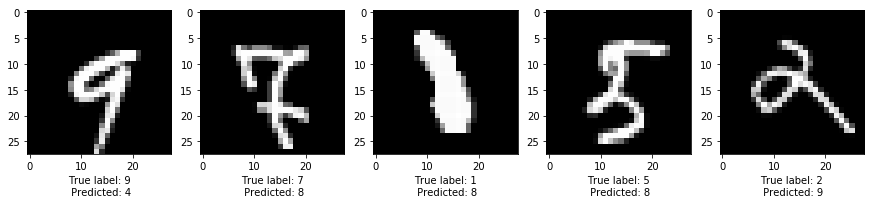

In [13]:
#Displaying 5 test images that the model misclassified
display(Markdown("<h4>5 Incorrectly classified test images</h4>"))
ind = random.sample(test_incorrect,5)
fig = plt.figure(figsize=(15,10))
for i,item in enumerate(ind):
    image = item[0].cpu().numpy().reshape(28,28)
    pred = item[1].item()
    label = item[2].item()
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xlabel("True label: {}\n Predicted: {}".format(label,pred))
    plt.imshow(image,cmap="gray")